In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [23]:
# Загрузка и предобработка данных (MNIST Fashion)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [24]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Распрямляем изображение
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
def train_model(model, num_epochs, criterion, optimizer, trainloader, testloader):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_test_loss = 0.0

        # Обучение
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(trainloader))
        print(f'Epoch {epoch + 1}, Train Loss: {running_train_loss / len(trainloader)}')

        # Сохранение потерь на тестовой выборке
        model.eval()
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

        test_losses.append(running_test_loss / len(testloader))

    print('Обучение завершено')
    return train_losses, test_losses

In [26]:
# Размерности слоев
input_size = 28 * 28
hidden_size1 = 512
hidden_size2 = 256
output_size = 10

model = SimpleClassifier(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 20

In [4]:
def plot_train_test_losses(train_losses, test_losses, num_epochs):
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.show()


In [15]:
train_losses, test_losses = train_model(model, num_epochs, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 0.48612448791546353
Epoch 2, Train Loss: 0.3669594459410415
Epoch 3, Train Loss: 0.3257819738294651
Epoch 4, Train Loss: 0.30123181559288426
Epoch 5, Train Loss: 0.27716686922921807
Epoch 6, Train Loss: 0.2635426131932974
Epoch 7, Train Loss: 0.24767135334675755
Epoch 8, Train Loss: 0.23323686018999198
Epoch 9, Train Loss: 0.21751683003215522
Epoch 10, Train Loss: 0.2106432237310895
Epoch 11, Train Loss: 0.19865936899919118
Epoch 12, Train Loss: 0.18980418652820308
Epoch 13, Train Loss: 0.17956593050273942
Epoch 14, Train Loss: 0.16926574786461746
Epoch 15, Train Loss: 0.16317221728651954
Epoch 16, Train Loss: 0.15298454274139456
Epoch 17, Train Loss: 0.14701727252286761
Epoch 18, Train Loss: 0.14133481791556707
Epoch 19, Train Loss: 0.13299434718344288
Epoch 20, Train Loss: 0.12613090497058338
Обучение завершено


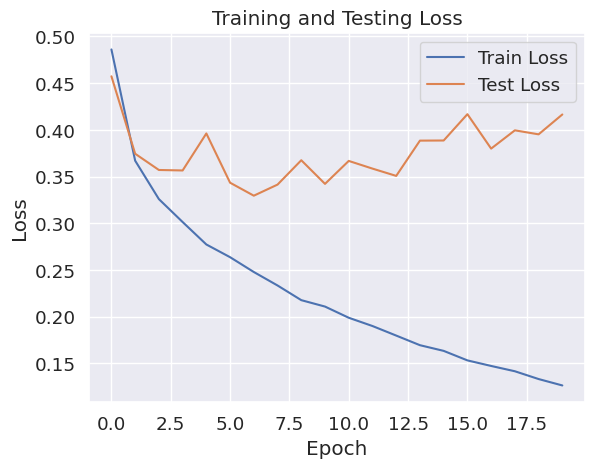

Точность на тестовом множестве: 89.29%


In [16]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

# Тестирование модели
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Точность на тестовом множестве: {accuracy:.2f}%')

### Видим явное переобучение модели. Применим Early Stopping для избежания переобучения

In [5]:
# Новая функция обучения с Early Stopping
def train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader):
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')  # Изначально устанавливаем её как бесконечность
    best_epoch = 0

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_test_loss = 0.0

        # Обучение
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(trainloader))

        # Сохранение потерь на тестовой выборке
        model.eval()
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

        test_losses.append(running_test_loss / len(testloader))
        print(f'Epoch {epoch + 1}, Train Loss: {running_train_loss / len(trainloader)}. Test Loss: {running_test_loss / len(testloader)}')

        # Early stopping
        if test_losses[-1] < best_test_loss:
            best_test_loss = test_losses[-1]
            best_epoch = epoch

        if epoch - best_epoch >= patience:
            print(f'Ранняя остановка на эпохе {epoch+1}. Лучший результат достигнут на эпохе {best_epoch+1}.')
            break

    print('Обучение завершено')
    return train_losses, test_losses

In [47]:
input_size = 28 * 28
hidden_size1 = 512
hidden_size2 = 256
output_size = 10

model = SimpleClassifier(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 20

In [48]:
patience = 2 # Значение, отвечающее за остановку обучения, если результат не улучшится в течение `patience` эпох
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 0.48833483622780743. Test Loss: 0.416852336685369
Epoch 2, Train Loss: 0.36354681297437724. Test Loss: 0.38554688044794044
Epoch 3, Train Loss: 0.3283615067426457. Test Loss: 0.3640096373144229
Epoch 4, Train Loss: 0.30276523180194753. Test Loss: 0.352005627907955
Epoch 5, Train Loss: 0.2797680841341837. Test Loss: 0.3317766997275079
Epoch 6, Train Loss: 0.2633599411370531. Test Loss: 0.3452825683293639
Epoch 7, Train Loss: 0.24818925067051642. Test Loss: 0.33702539306157714
Ранняя остановка на эпохе 7. Лучший результат достигнут на эпохе 5.
Обучение завершено


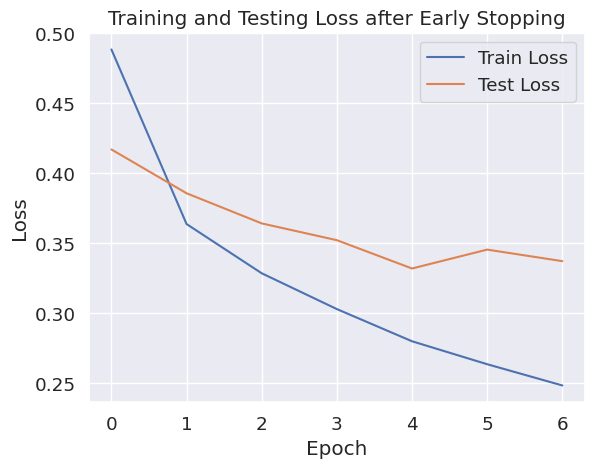

In [49]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

In [50]:
# Тестирование модели
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Точность на тестовом множестве: {accuracy:.2f}%')

Точность на тестовом множестве: 88.00%


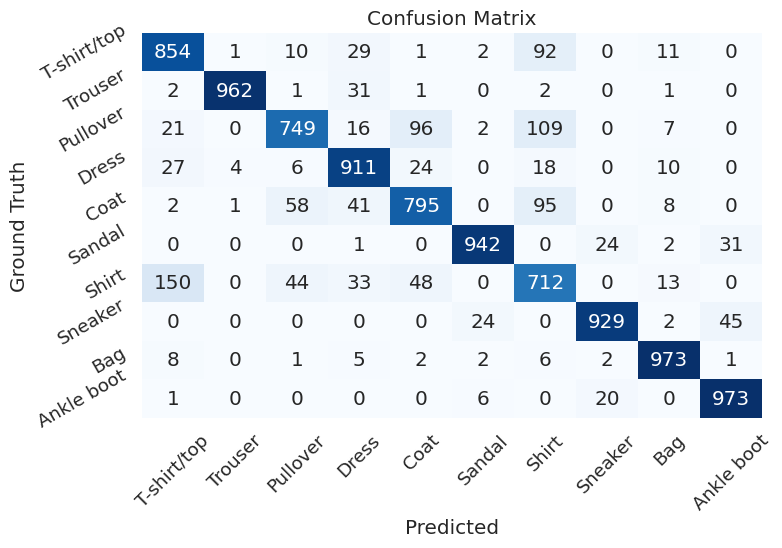

In [51]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = trainset.classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45)
plt.yticks(tick_marks + 0.5, class_names, rotation=30)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

In [52]:
# Сохранение модели
torch.save(model.state_dict(), 'simple_classifier.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [53]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [56]:
input_channels = 1
num_classes = 10
model = ConvNet(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 20
patience = 2
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 0.4046660831758081. Test Loss: 0.342867527987547
Epoch 2, Train Loss: 0.273459642633065. Test Loss: 0.29704246352052993
Epoch 3, Train Loss: 0.23049251226855239. Test Loss: 0.26986196774775817
Epoch 4, Train Loss: 0.19709056033603928. Test Loss: 0.25778405420529615
Epoch 5, Train Loss: 0.17125619244156107. Test Loss: 0.25164484161480216
Epoch 6, Train Loss: 0.15025046121265526. Test Loss: 0.2761211281369446
Epoch 7, Train Loss: 0.1299702545373774. Test Loss: 0.26030793124038704
Ранняя остановка на эпохе 7. Лучший результат достигнут на эпохе 5.
Обучение завершено


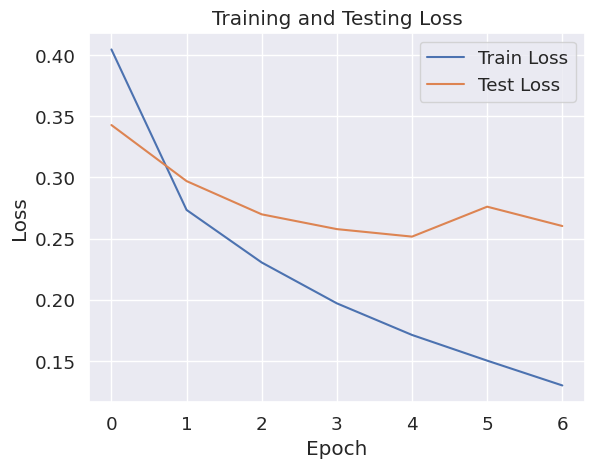

Точность на тестовом множестве: 91.34%


In [59]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

# Тестирование модели
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())


accuracy = 100 * correct / total
print(f'Точность на тестовом множестве: {accuracy:.2f}%')

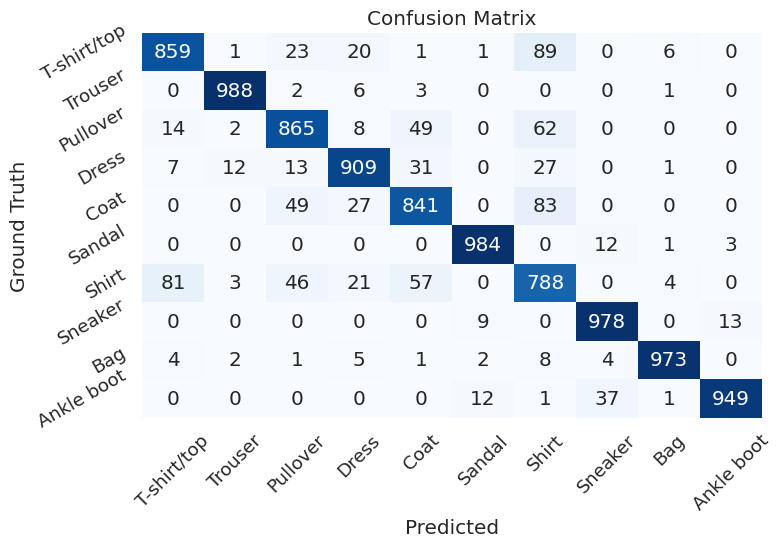

In [60]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = trainset.classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45)
plt.yticks(tick_marks + 0.5, class_names, rotation=30)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

In [61]:
# Сохранение модели
torch.save(model.state_dict(), 'simple_classifier_cnn.pth')

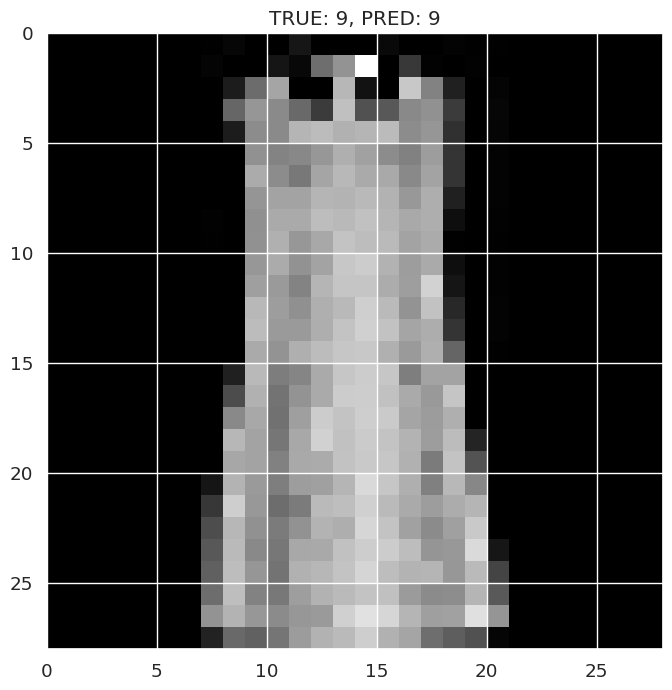

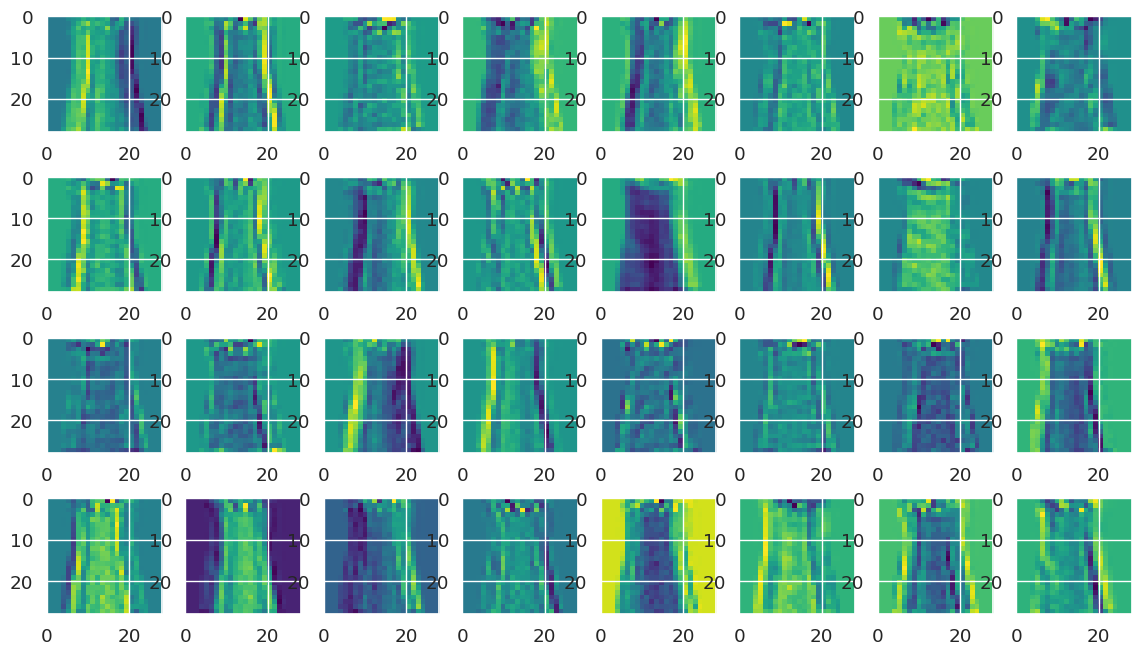

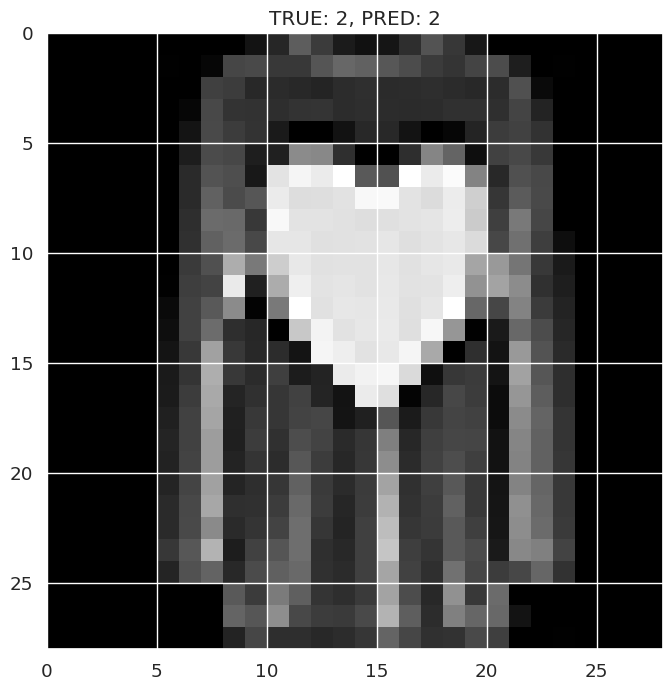

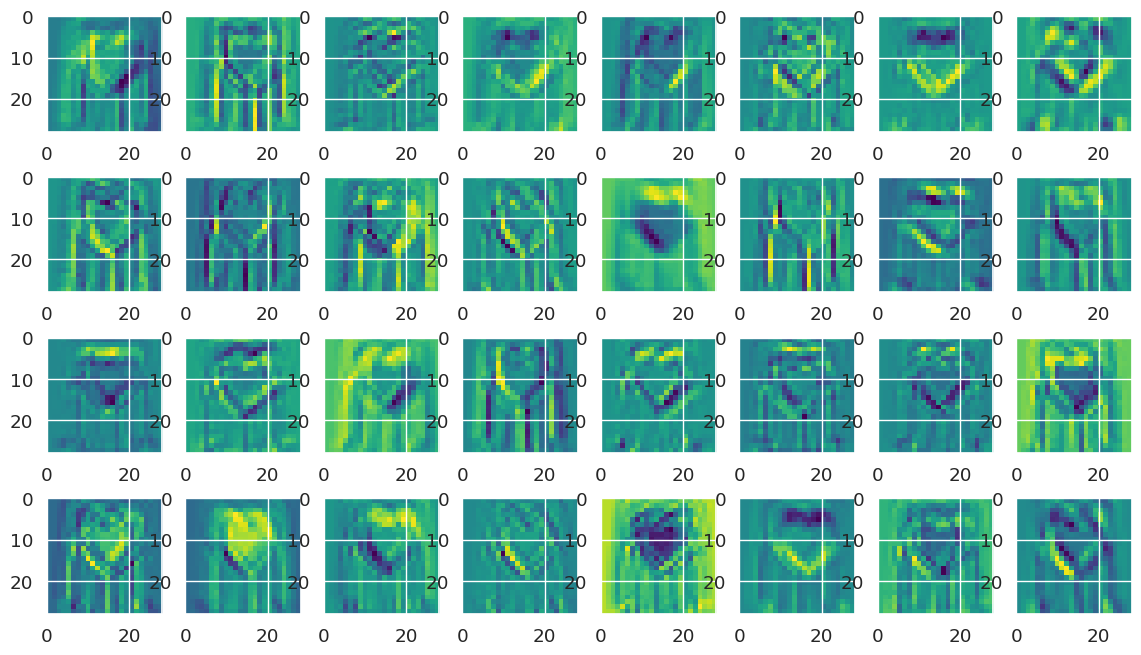

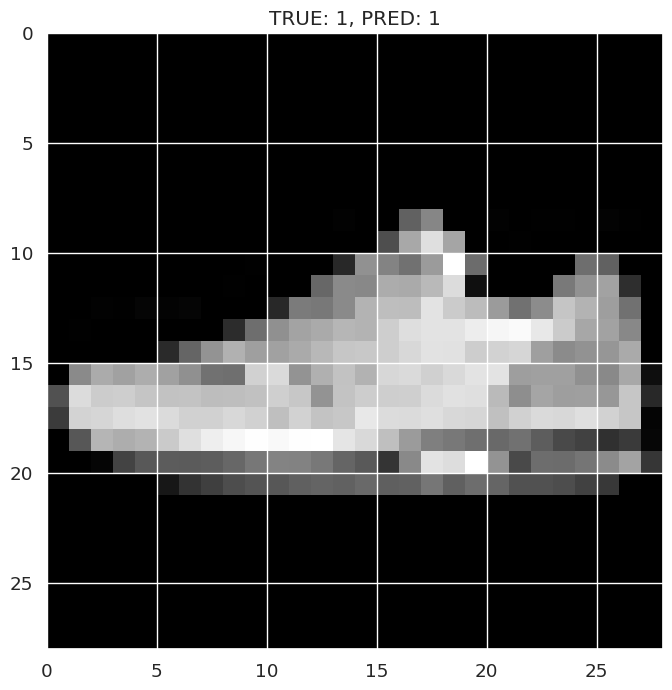

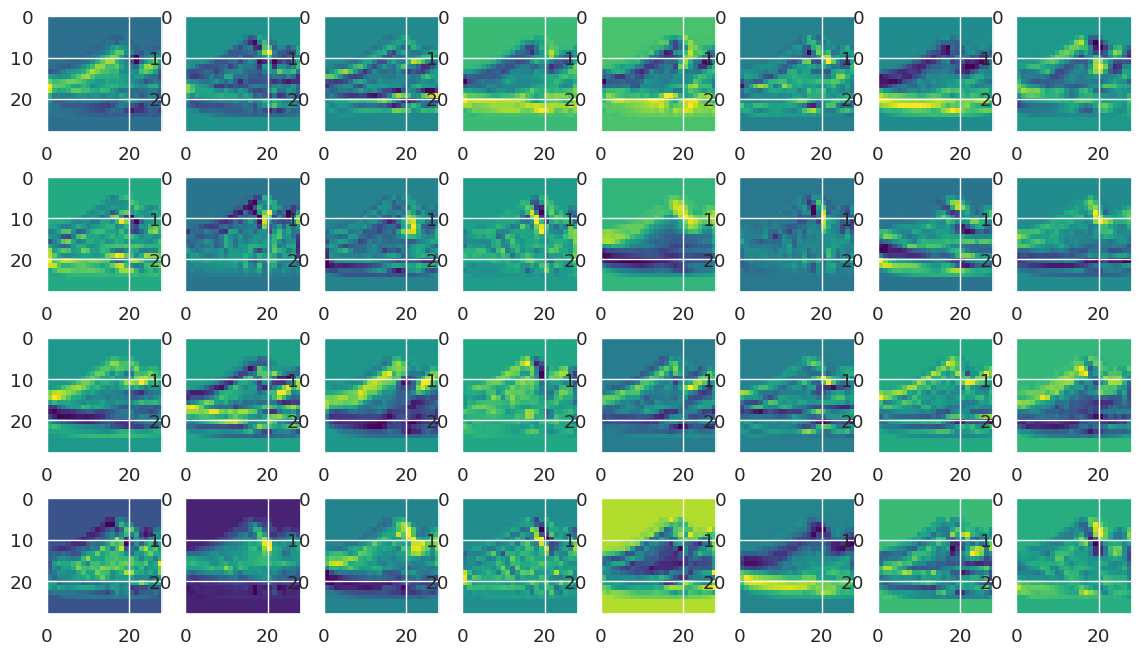

In [62]:
for i in range(3):
    image = images[i].cpu().squeeze().numpy()
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    plt.figure(figsize=(8, 8))
    plt.title(f"TRUE: {true_label}, PRED: {predicted_label}")
    plt.imshow(image, cmap='gray', extent=[0, 28, 28, 0])

    conv1_output = model.conv1(images)
    fig, ax = plt.subplots(4, 8, figsize=(14, 8))
    j = 0
    for axi in ax:
        for axj in axi:
            axj.imshow(conv1_output[i][j].cpu().detach().numpy(), cmap='viridis', extent=[0, 28, 28, 0])
            j += 1
    plt.show()

##  2. Классификация изображений (датасет CIFAR 10)


### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [64]:
# Загрузим CIFAR-10 и нормализуем данные
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [66]:
input_size = 32 * 32 * 3
hidden_size1 = 512
hidden_size2 = 128
output_size = 10

model = SimpleClassifier(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
patience = 2
num_epochs = 20

In [69]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 1.641665612797603. Test Loss: 1.4815088981276106
Epoch 2, Train Loss: 1.4343121772074638. Test Loss: 1.4035806777370963
Epoch 3, Train Loss: 1.3220796752768709. Test Loss: 1.4278063045185843
Epoch 4, Train Loss: 1.233115462086085. Test Loss: 1.3724909375427634
Epoch 5, Train Loss: 1.1562520068167421. Test Loss: 1.373030079777833
Epoch 6, Train Loss: 1.0861132707437287. Test Loss: 1.3773023208994775
Ранняя остановка на эпохе 6. Лучший результат достигнут на эпохе 4.
Обучение завершено


In [6]:
# Тестирование модели
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())

    # Возвращаем accuracy и F1-score
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1


In [71]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 0.52%
Взвешенный F1 Score на тестовом множестве: 0.52%


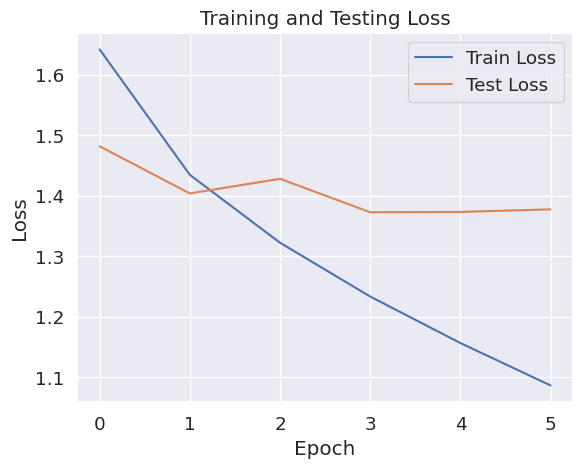

In [72]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

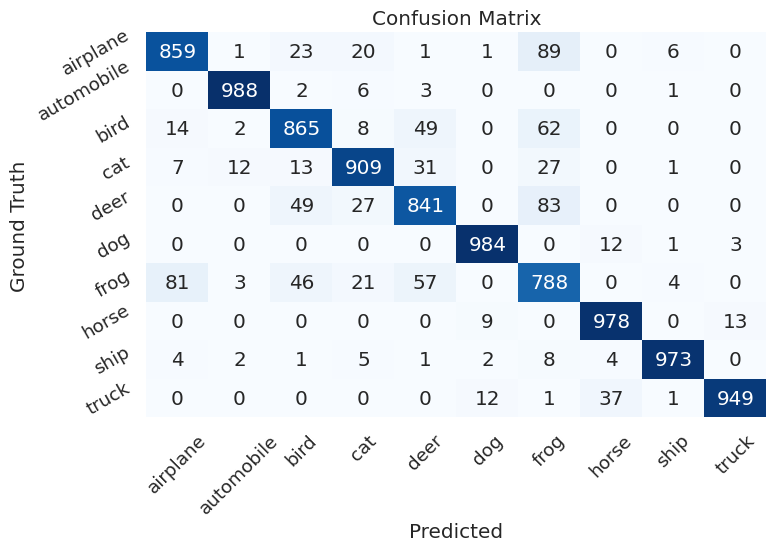

In [73]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = trainset.classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45)
plt.yticks(tick_marks + 0.5, class_names, rotation=30)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [81]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [84]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
patience = 2
num_epochs = 20

In [85]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 1.3599431671754783. Test Loss: 1.1197897507126924
Epoch 2, Train Loss: 0.9832319897763869. Test Loss: 0.9415847537623849
Epoch 3, Train Loss: 0.8300465598054554. Test Loss: 0.8810695918502321
Epoch 4, Train Loss: 0.7186241281764282. Test Loss: 0.8523651065340467
Epoch 5, Train Loss: 0.6252157919089812. Test Loss: 0.8604820366877659
Epoch 6, Train Loss: 0.5313749664541706. Test Loss: 0.8686325071723597
Ранняя остановка на эпохе 6. Лучший результат достигнут на эпохе 4.
Обучение завершено


In [88]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 71.21%
Взвешенный F1 Score на тестовом множестве: 0.71


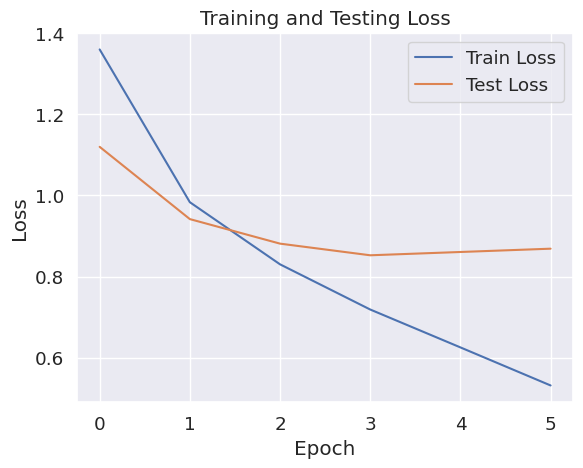

In [89]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

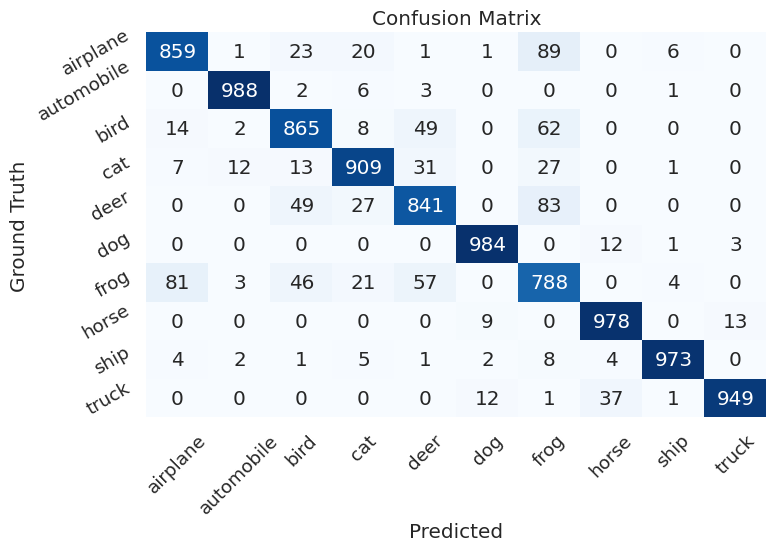

In [90]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = trainset.classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45)
plt.yticks(tick_marks + 0.5, class_names, rotation=30)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

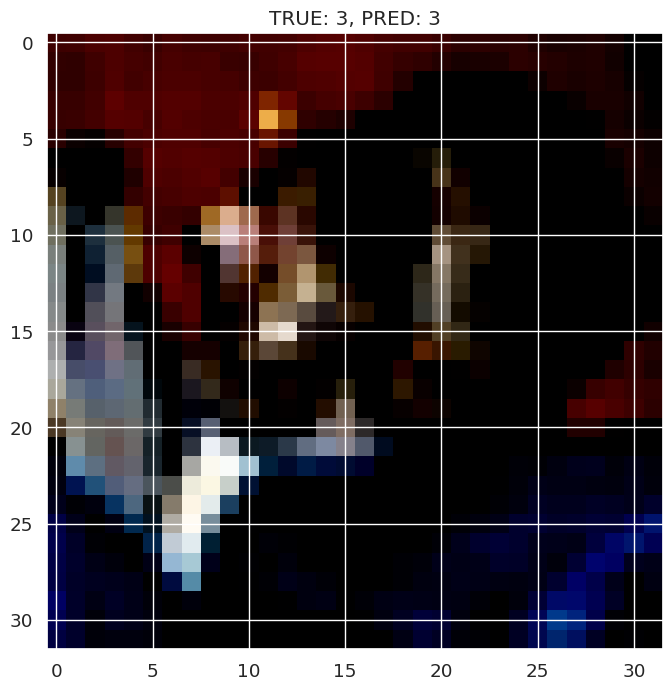

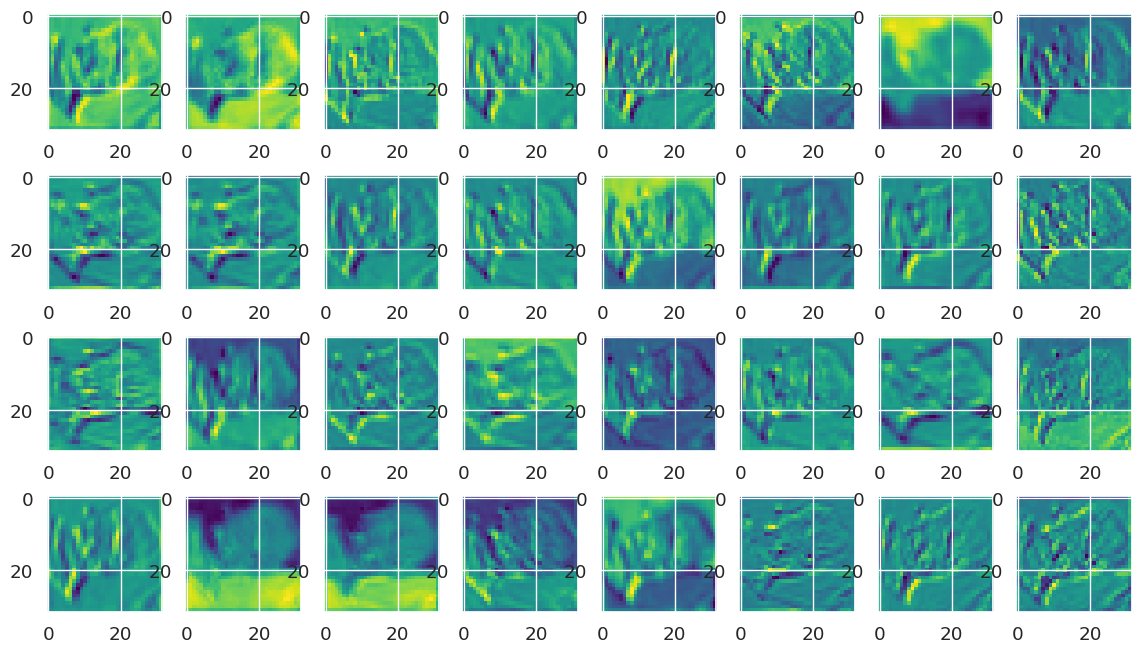

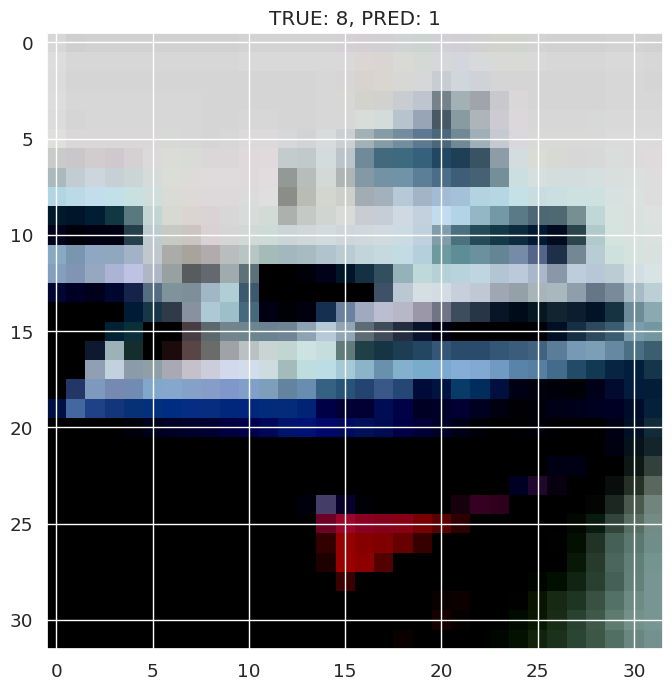

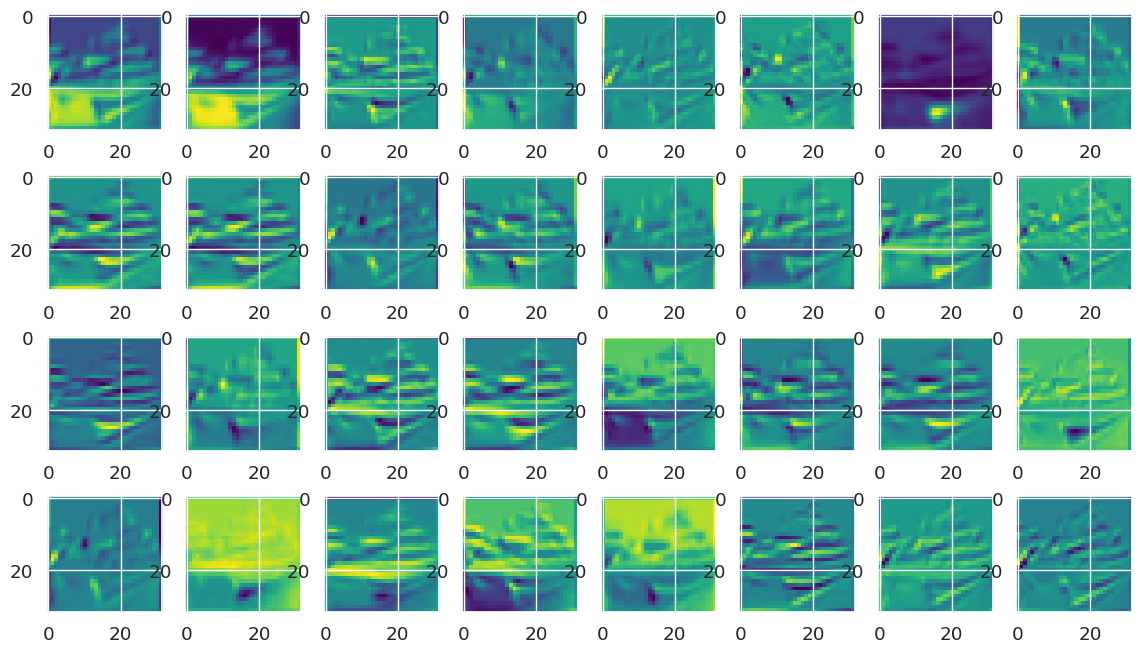

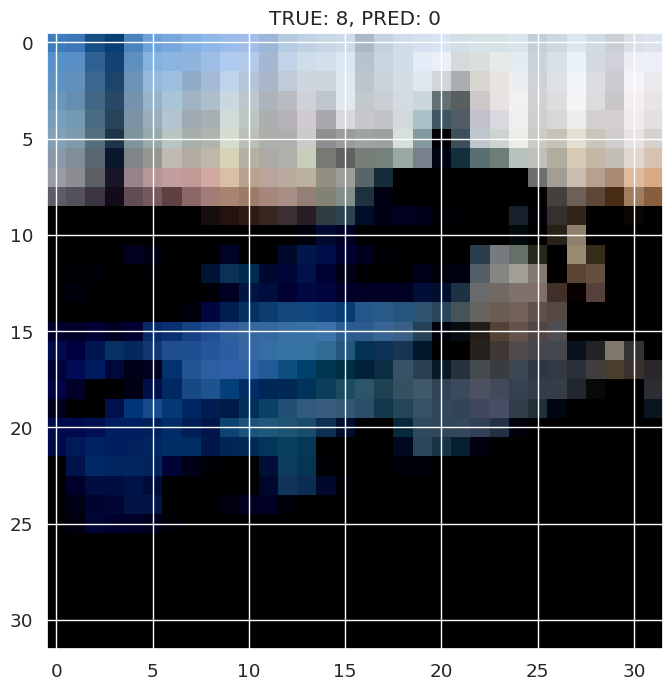

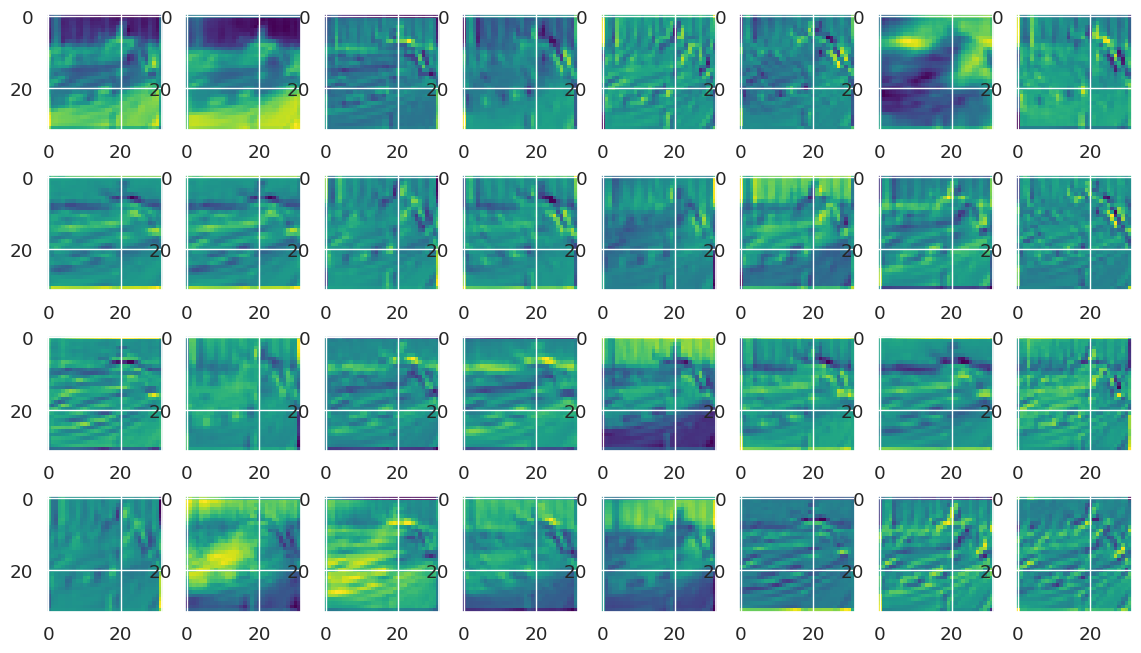

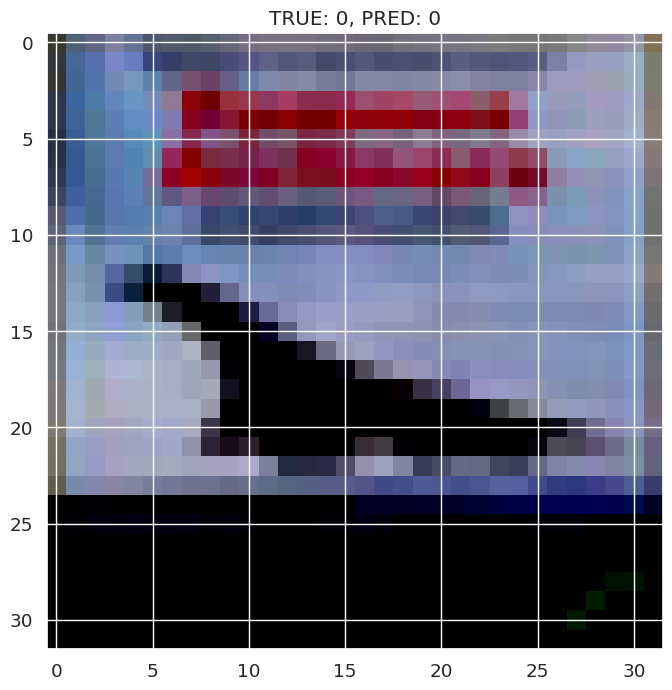

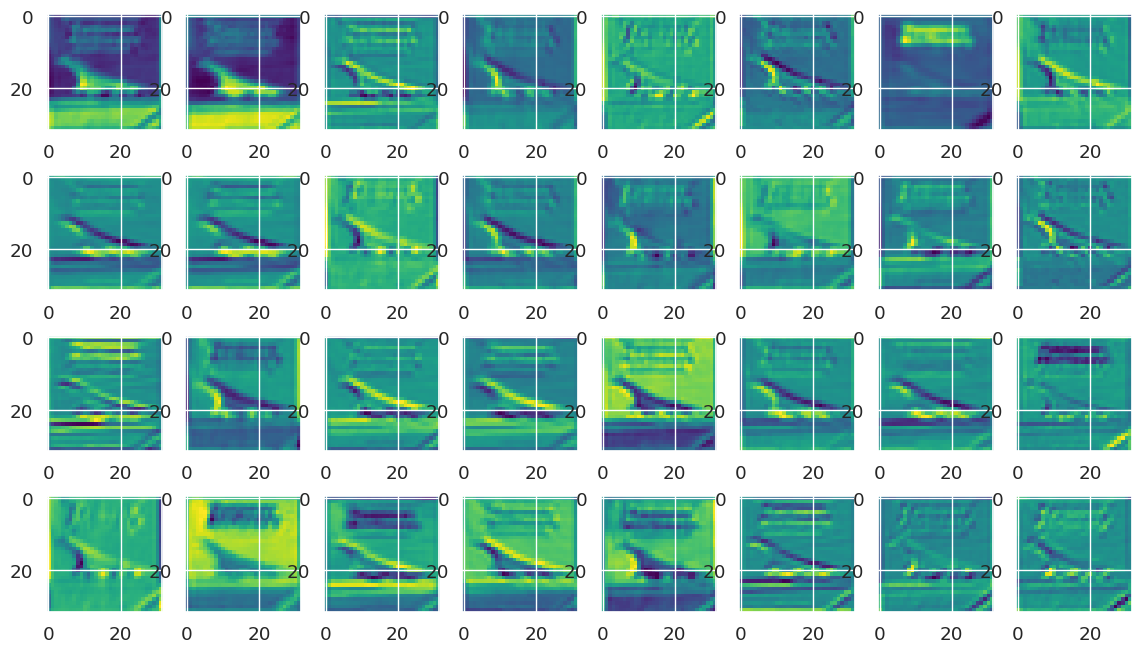

In [93]:
# Определение функции для визуализации сверточных фильтров и их выходов
def visualize_conv1_output(model, dataloader, num_samples=4):
    model.eval()
    sample_count = 0  # Переменная для отслеживания числа обработанных образцов
    for i, data in enumerate(dataloader):
        if sample_count >= num_samples:
            break
        images, labels = data
        conv1_output = model.conv1(images)
        predicted_labels = model(images).argmax(1)

        for j in range(len(images)):
            if sample_count >= num_samples:
                break
            image = images[j].cpu().squeeze().numpy()
            true_label = labels[j].item()
            predicted_label = predicted_labels[j].item()

            plt.figure(figsize=(8, 8))
            plt.title(f"TRUE: {true_label}, PRED: {predicted_label}")
            plt.imshow(image.transpose(1, 2, 0))

            fig, ax = plt.subplots(4, 8, figsize=(14, 8))
            for k in range(4):
                for l in range(8):
                    ax[k, l].imshow(conv1_output[j, 8 * k + l].cpu().detach().numpy(), cmap='viridis')
            plt.show()
            sample_count += 1

# Вызов функции для визуализации (для первых 4 изображений)
visualize_conv1_output(model, testloader, num_samples=4)


## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [7]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [7]:
categories = {
    "mantled_howler":0,
    "patas_monkey":1,
    "bald_uakari":2,
    "japanese_macaque":3,
    "pygmy_marmoset":4,
    "white_headed_capuchin":5,
    "silvery_marmoset":6,
    "common_squirrel_monkey":7,
    "black_headed_night_monkey":8,
    "nilgiri_langur":9
}

In [11]:
train_dir = 'D:/VUZ_jupiter/datasets/monkeys/training/training/'
val_dir = 'D:/VUZ_jupiter/datasets/monkeys/validation/validation/'

In [12]:
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
monkeys_train = torchvision.datasets.ImageFolder(train_dir, transform=train_tfms)
monkeys_test = torchvision.datasets.ImageFolder(val_dir, transform=valid_tfms)

In [22]:
class MonkeyModel(nn.Module):
    def __init__(self):
        super(MonkeyModel, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding = 1), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=5, stride=1, padding = 1),
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(12800, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
trainloader = torch.utils.data.DataLoader(monkeys_train, 16, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(monkeys_test, 16, num_workers=4, pin_memory=True)

In [28]:
num_epochs = 20
patience = 2
model = MonkeyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0e-4)

In [29]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 2.029739170834638. Test Loss: 1.7243488921838648
Epoch 2, Train Loss: 1.4963007940762285. Test Loss: 1.4579171783783857
Epoch 3, Train Loss: 1.2675505211387856. Test Loss: 1.3437258005142212
Epoch 4, Train Loss: 1.0425719506498696. Test Loss: 1.3223043697721817
Epoch 5, Train Loss: 0.9264093205548715. Test Loss: 1.1917909453896915
Epoch 6, Train Loss: 0.7438239761884662. Test Loss: 1.1291542079518824
Epoch 7, Train Loss: 0.6492289883503015. Test Loss: 1.2185955275507534
Epoch 8, Train Loss: 0.5124744926241861. Test Loss: 1.126770492643118
Epoch 9, Train Loss: 0.42468416690826416. Test Loss: 1.1562560665256836
Epoch 10, Train Loss: 0.3029423817128375. Test Loss: 1.1758734829285566
Ранняя остановка на эпохе 10. Лучший результат достигнут на эпохе 8.
Обучение завершено


In [30]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 66.18%
Взвешенный F1 Score на тестовом множестве: 0.66


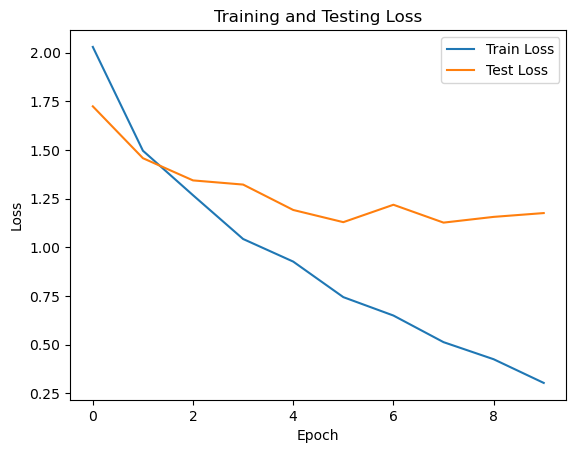

In [31]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

In [33]:
# Тестирование модели
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

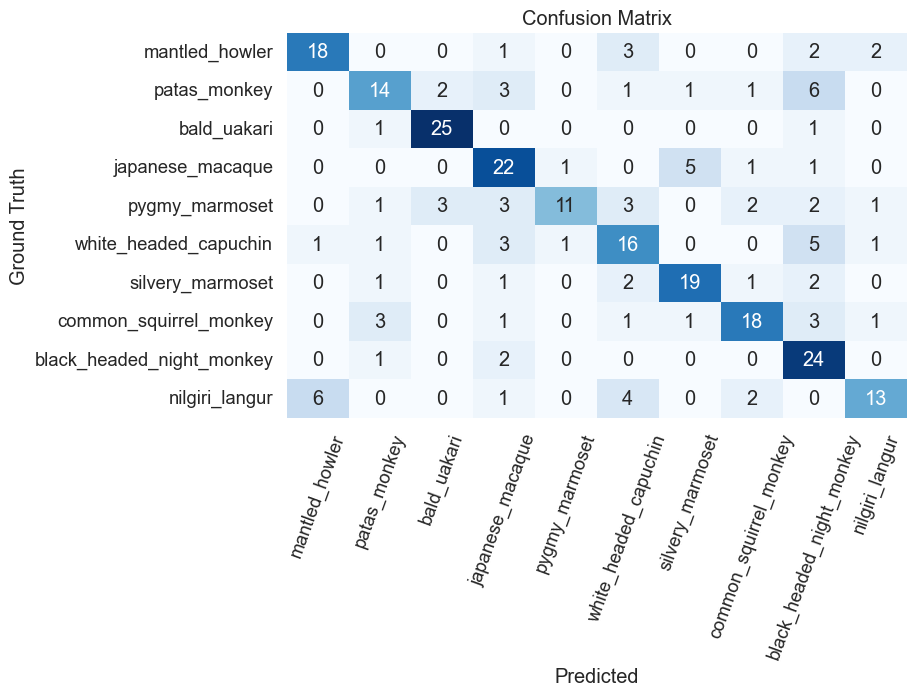

In [39]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = categories
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=70)
plt.yticks(tick_marks + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


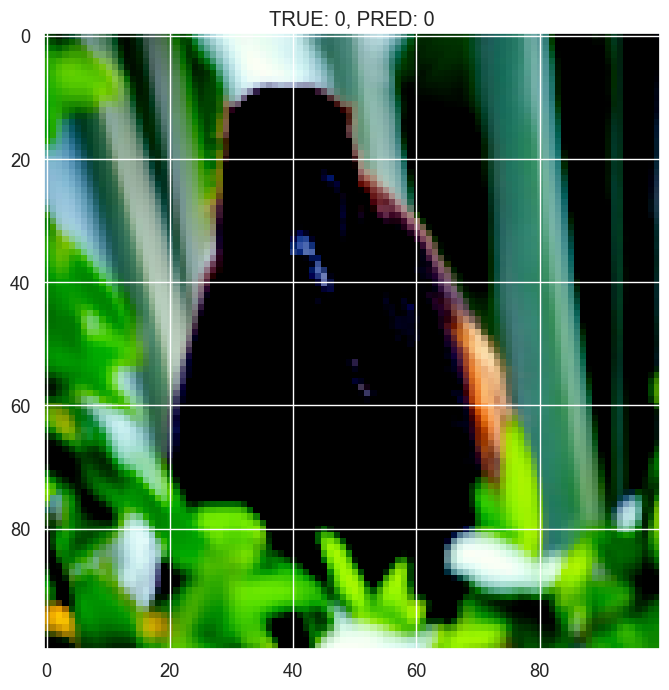

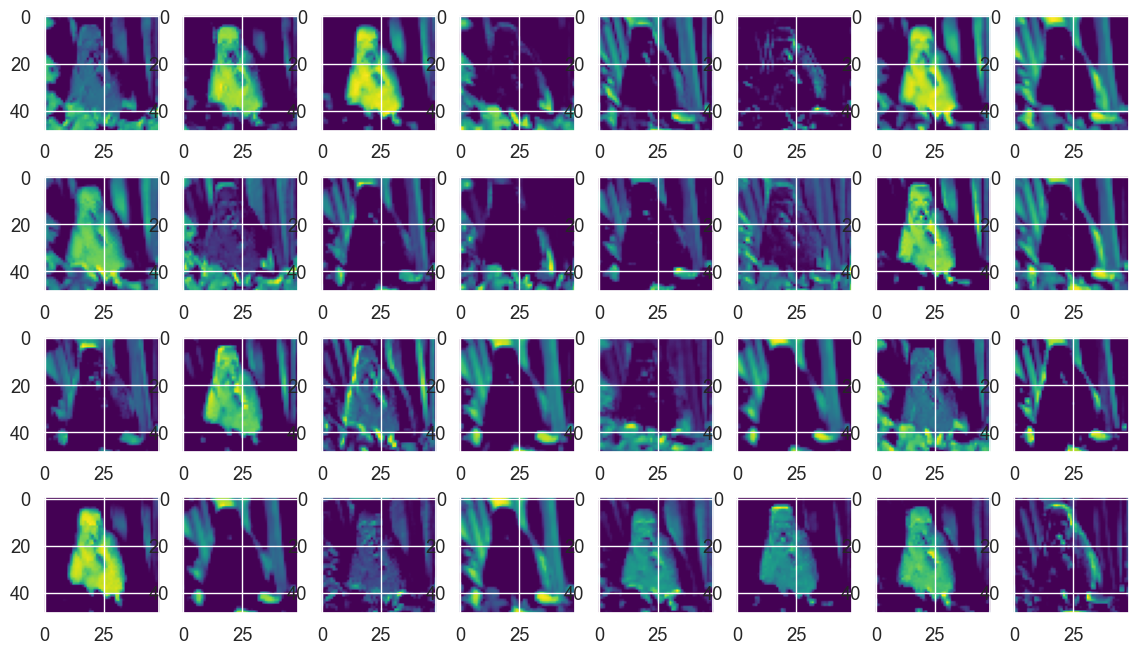

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


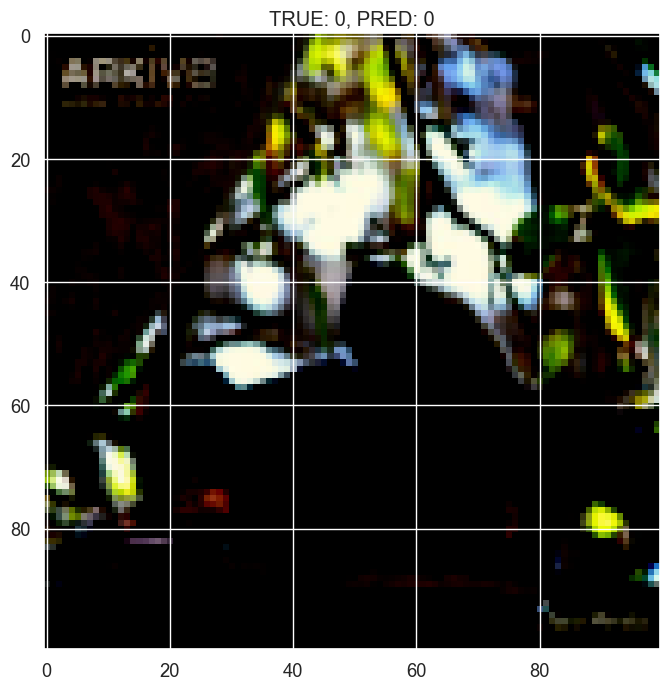

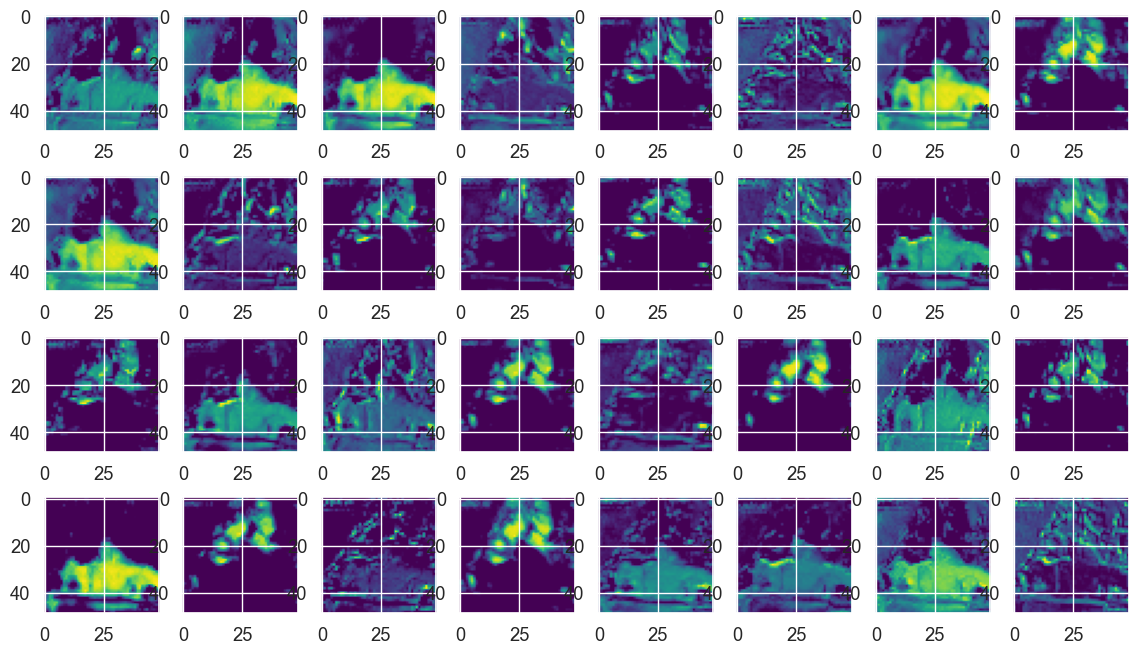

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


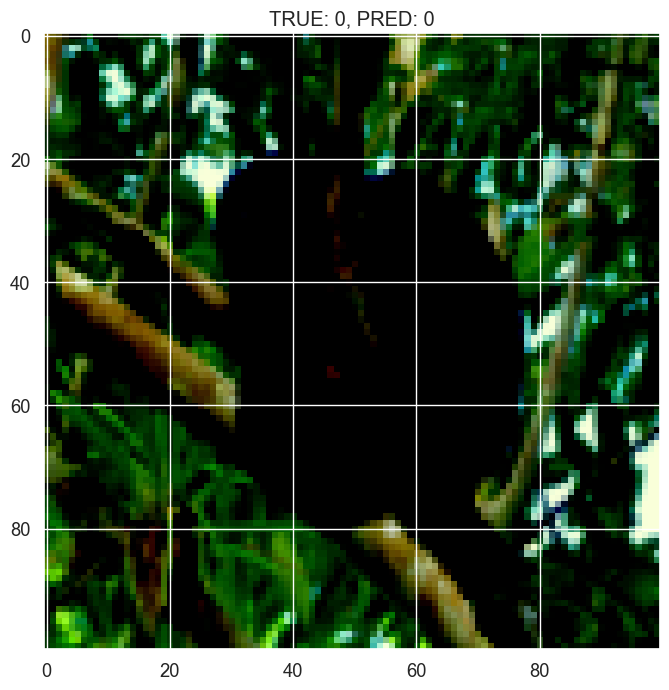

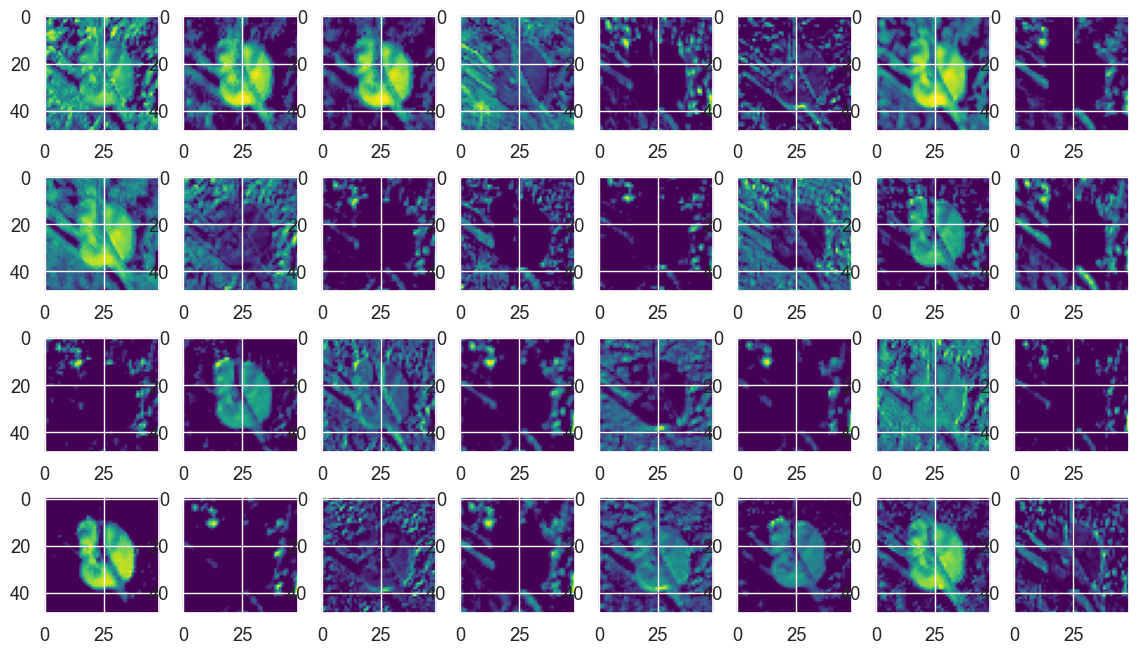

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


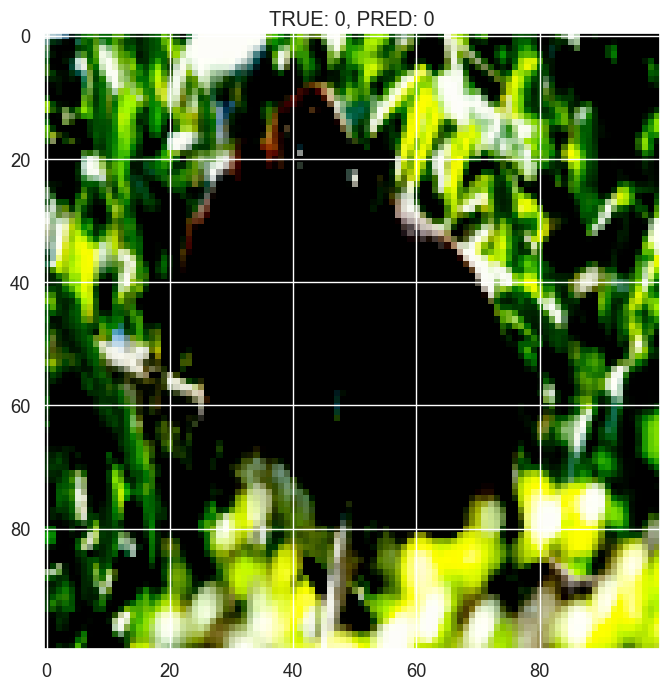

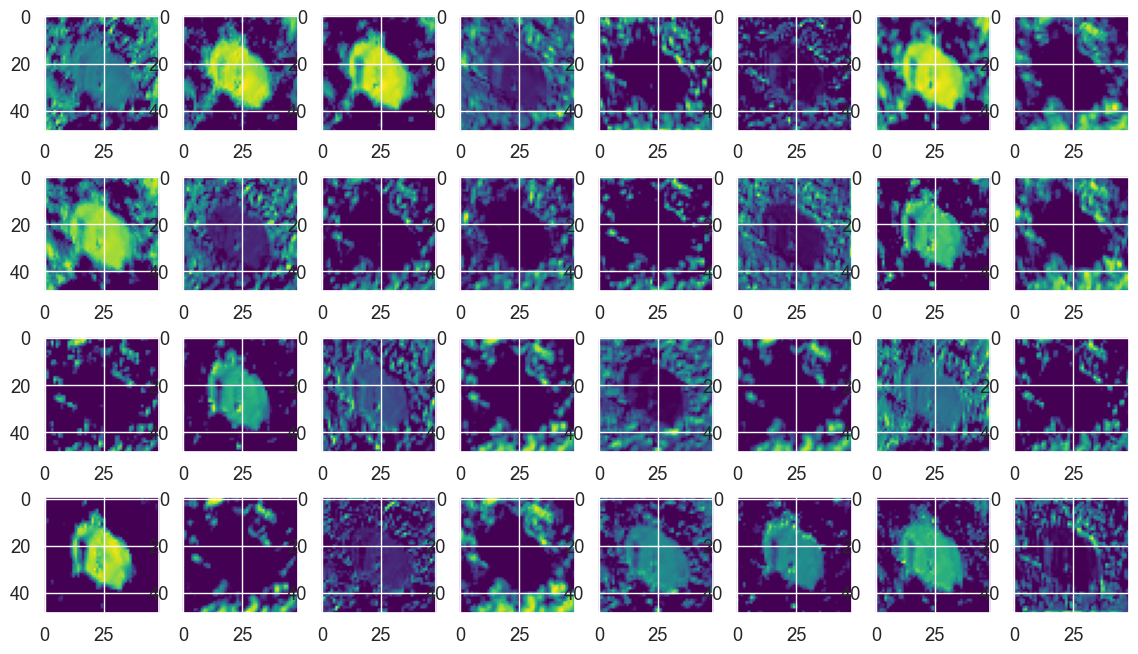

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


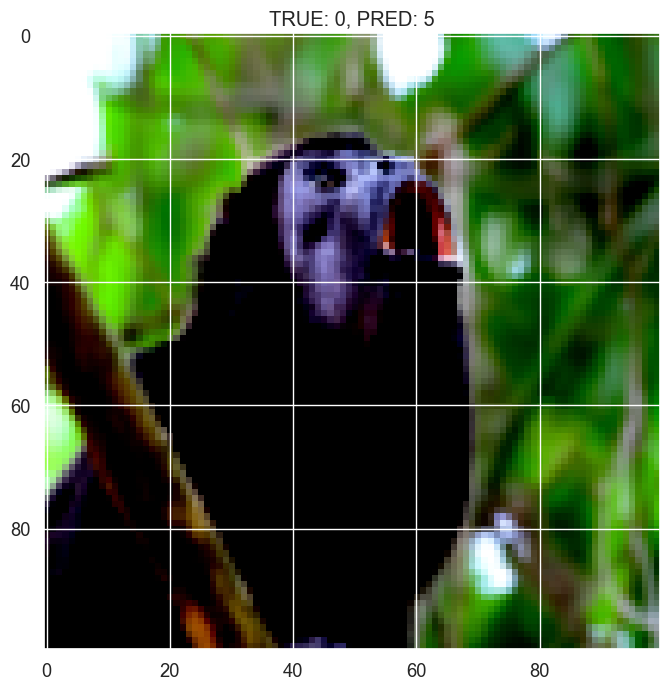

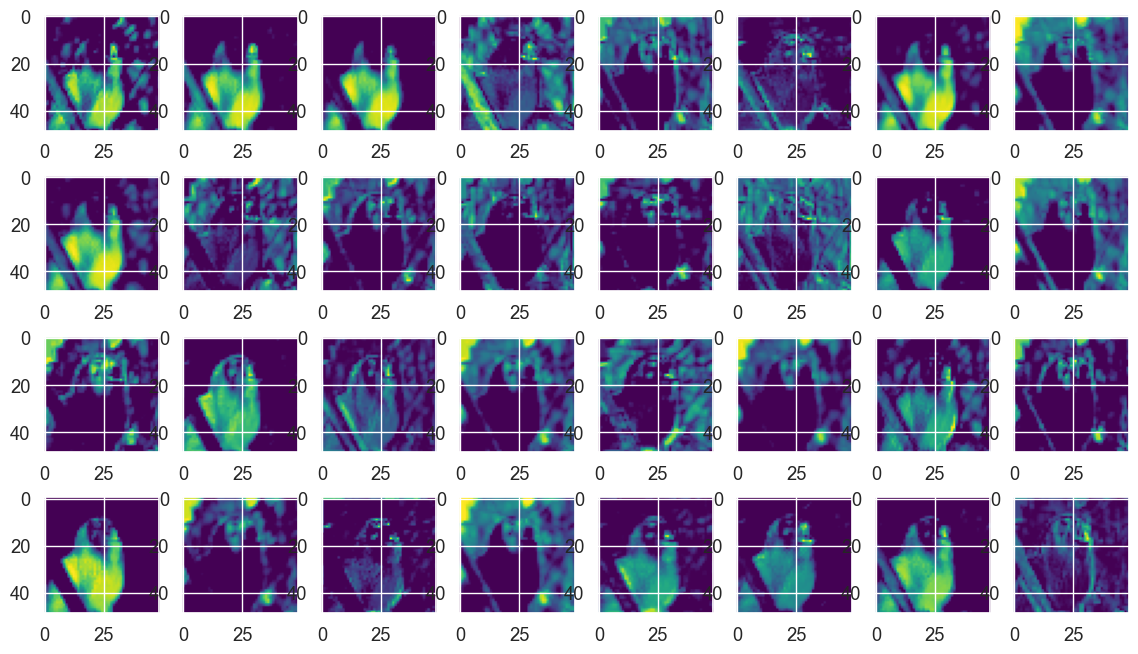

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


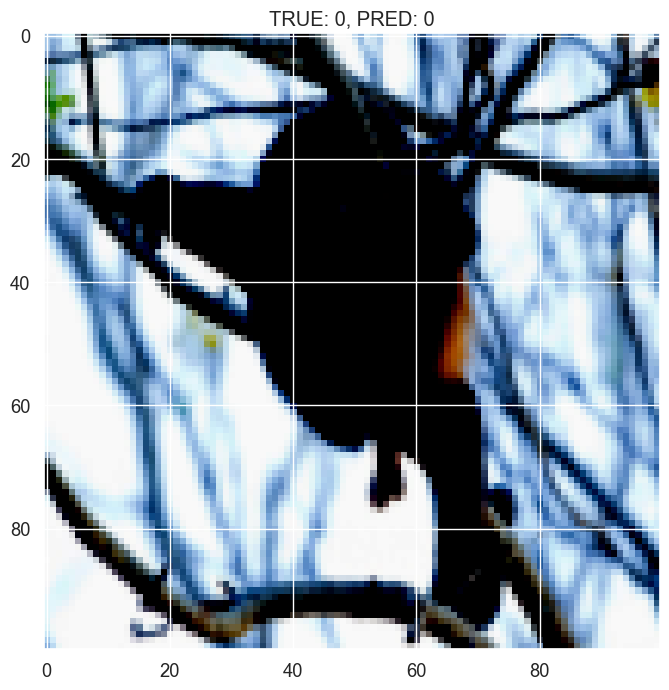

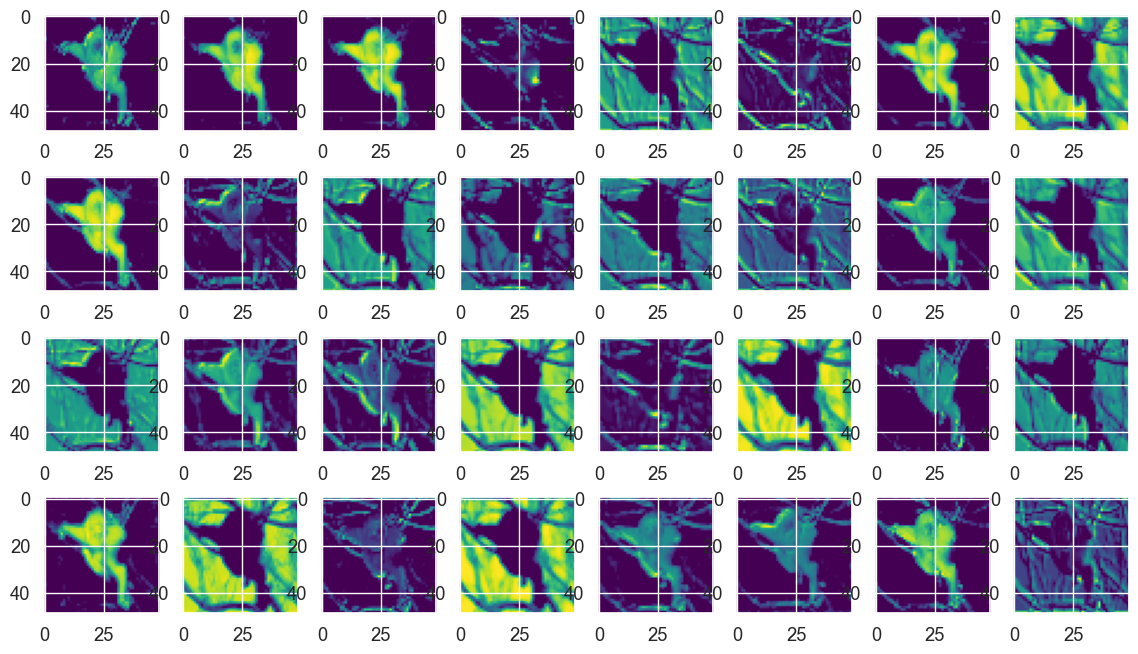

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


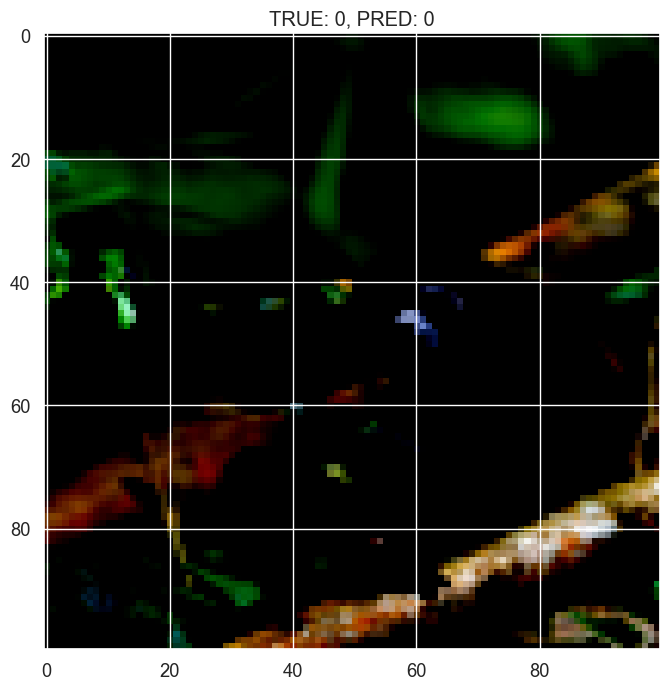

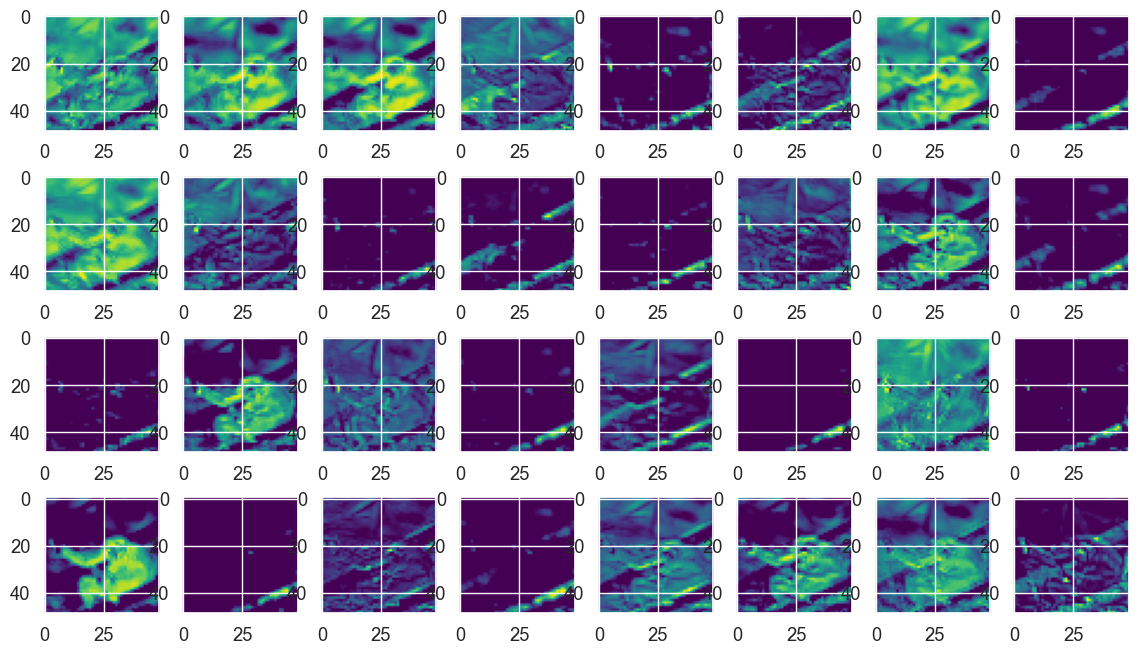

In [44]:
import matplotlib.pyplot as plt

def visualize_conv1_output(model, dataloader, num_samples=4):
    model.eval()
    sample_count = 0  # Переменная для отслеживания числа обработанных образцов

    for i, data in enumerate(dataloader):
        if sample_count >= num_samples:
            break
        images, labels = data
        conv1_output = model.layer1(images)
        predicted_labels = model(images).argmax(1)

        for j in range(len(images)):
            if sample_count >= num_samples:
                break
            image = images[j].cpu().squeeze().numpy()
            true_label = labels[j].item()
            predicted_label = predicted_labels[j].item()

            plt.figure(figsize=(8, 8))
            plt.title(f"TRUE: {true_label}, PRED: {predicted_label}")
            plt.imshow(image.transpose(1, 2, 0))

            fig, ax = plt.subplots(4, 8, figsize=(14, 8))
            for k in range(4):
                for l in range(8):
                    ax[k, l].imshow(conv1_output[j, 8 * k + l].cpu().detach().numpy(), cmap='viridis')
            plt.show()
            sample_count += 1

visualize_conv1_output(model, testloader, num_samples=7)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [25]:
import torchvision.models as models

In [45]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([64, 64]),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)

In [58]:
dataset = datasets.ImageFolder('D:/VUZ_jupiter/datasets/cats_dogs/cats_dogs/train/', transform=transform)
trainx, testx = torch.utils.data.random_split(dataset, [0.8, 0.2])

trainloader = torch.utils.data.DataLoader(dataset=trainx, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testx, batch_size=128, shuffle=False)

In [59]:
class SimpleClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(512, 2)
        self.model = model
    
    def forward(self, data):
        return self.model(data)

In [63]:
model = SimpleClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
patience = 2
num_epochs = 20

D:\Conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [64]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

D:\Conda\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Train Loss: 0.5760039309407495. Test Loss: 0.5849802114069462
Epoch 2, Train Loss: 0.43608953770558545. Test Loss: 0.5323155403137207
Epoch 3, Train Loss: 0.36961611004392053. Test Loss: 0.39002587683498857
Epoch 4, Train Loss: 0.3085909251384674. Test Loss: 0.3528422523289919
Epoch 5, Train Loss: 0.25831307613166277. Test Loss: 0.41873898543417454
Epoch 6, Train Loss: 0.20624018783212467. Test Loss: 0.3654957577586174
Ранняя остановка на эпохе 6. Лучший результат достигнут на эпохе 4.
Обучение завершено


In [68]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 85.14%
Взвешенный F1 Score на тестовом множестве: 0.85


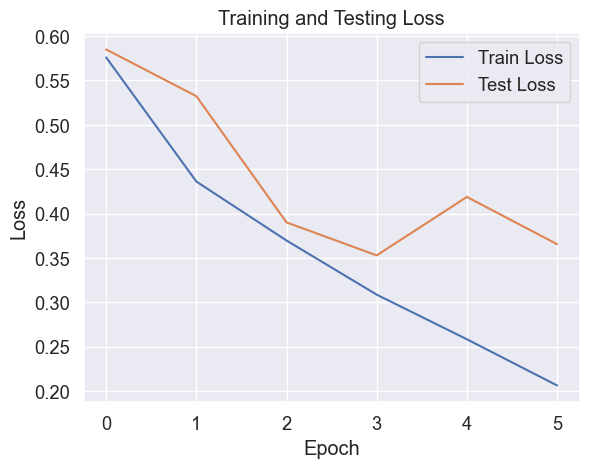

In [69]:
plot_train_test_losses(train_losses, test_losses, num_epochs)

In [70]:
# Тестирование модели
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

D:\Conda\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [71]:
categories = {'cat':-0, 'dog':1}

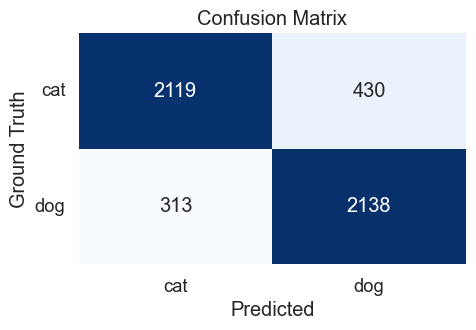

In [75]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_names = categories
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.title('Confusion Matrix')
plt.show()

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


In [22]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)

In [23]:
categories = {
    "mantled_howler":0,
    "patas_monkey":1,
    "bald_uakari":2,
    "japanese_macaque":3,
    "pygmy_marmoset":4,
    "white_headed_capuchin":5,
    "silvery_marmoset":6,
    "common_squirrel_monkey":7,
    "black_headed_night_monkey":8,
    "nilgiri_langur":9
}

In [26]:
model = models.vgg16(pretrained=True)
num_classes = len(categories)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

C:\Users\Drama\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Drama\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Drama/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [02:37<00:00, 3.50MB/s] 


In [11]:
train_dir = 'D:/VUZ_jupiter/datasets/monkeys/training/training/'
val_dir = 'D:/VUZ_jupiter/datasets/monkeys/validation/validation/'

In [13]:
monkeys_train = torchvision.datasets.ImageFolder(train_dir, transform=transform)
monkeys_test = torchvision.datasets.ImageFolder(val_dir, transform=transform)

In [16]:
trainloader = torch.utils.data.DataLoader(monkeys_train, 16, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(monkeys_test, 16, num_workers=4, pin_memory=True)

In [17]:
num_epochs = 20
patience = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 2.3688663745271987. Test Loss: 2.2796930705799774
Epoch 2, Train Loss: 2.2068170291790064. Test Loss: 2.1176115484798657
Epoch 3, Train Loss: 2.118520247763482. Test Loss: 2.1026597513872036
Epoch 4, Train Loss: 2.1143778821696406. Test Loss: 2.232972460634568
Epoch 5, Train Loss: 2.1041264879530757. Test Loss: 2.0522664925631355
Epoch 6, Train Loss: 2.048692952031675. Test Loss: 2.0693958857480217
Epoch 7, Train Loss: 2.0718342083087866. Test Loss: 2.1676440168829525
Ранняя остановка на эпохе 7. Лучший результат достигнут на эпохе 5.
Обучение завершено


In [20]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 17.65%
Взвешенный F1 Score на тестовом множестве: 0.12


In [22]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 2.0208169982053232. Test Loss: 2.0243055680218864
Epoch 2, Train Loss: 1.9687874749086904. Test Loss: 2.084374518955455
Epoch 3, Train Loss: 1.9894675569257874. Test Loss: 2.0485072767033294
Ранняя остановка на эпохе 3. Лучший результат достигнут на эпохе 1.
Обучение завершено


In [24]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')

Точность на тестовом множестве: 23.16%
Взвешенный F1 Score на тестовом множестве: 0.15


In [33]:
model = models.vgg16(pretrained=True)

In [27]:
for param in model.parameters():
    param.requires_grad = False

model.classifier.add_module('vktrbr_linear', torch.nn.Linear(1000, 10))    

for param in model.classifier:
    param.requires_grad = True



In [35]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

Epoch 1, Train Loss: 4.211853714956754. Test Loss: 3.85897055794211
Epoch 2, Train Loss: 4.244618222333383. Test Loss: 3.85897055794211
Epoch 3, Train Loss: 4.184579838877139. Test Loss: 3.85897055794211
Ранняя остановка на эпохе 3. Лучший результат достигнут на эпохе 1.
Обучение завершено


In [36]:
test_accuracy, test_f1 = test_model(model, testloader)
print(f'Точность на тестовом множестве: {test_accuracy*100:.2f}%')
print(f'Взвешенный F1 Score на тестовом множестве: {test_f1:.2f}')


Точность на тестовом множестве: 12.87%
Взвешенный F1 Score на тестовом множестве: 0.06


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [29]:
model = torchvision.models.resnet18(pretrained=True)

C:\Users\Drama\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Drama\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)

In [31]:
dataset = datasets.ImageFolder('D:/cats_dogs/cats_dogs/train/', transform=transform)
trainx, testx = torch.utils.data.random_split(dataset, [0.8, 0.2])

trainloader = torch.utils.data.DataLoader(dataset=trainx, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testx, batch_size=128, shuffle=False)

In [32]:
model.add_module('vktrbr_linear', torch.nn.Linear(1000, 10))

In [33]:
num_epochs = 20
patience = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses = train_model(model, num_epochs, patience, criterion, optimizer, trainloader, testloader)

C:\Users\Drama\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
